In [1]:
## imports

import os
import subprocess
import numpy as np
import tensorflow as tf
from osgeo import gdal
from osgeo import ogr
import matplotlib.pyplot as plt

In [2]:
## settings

# inputs
dinp = "D:\\uni\\deep" # dir input
fimg = os.path.join(dinp, "image.tif") # image file name
fshp = os.path.join(dinp, "hymap_lcz_test.shp") # shp file name
attr = "classNum" # col name of class labels in shapefile
tbdir = "C:\\Users\\Gekko\\Anaconda3\\Scripts\\tensorboard" # dir tb
target = os.path.join(dinp, "subset.tif") # temp: image subset for classification

# outputs
dpat = os.path.join(dinp, "mg_patches") # output dir image patches
modelpath = os.path.join(dinp, "tf_model", "TFmodel.ckpt") # output model save
tblog = os.path.join(dinp, "tb_logs") # tb dir logs
tblogtrain = os.path.join(tblog, "train") # tb logs train
tblogtest = os.path.join(tblog, "test") # tb logs test

# network settings
patchesPerClass = 7
patchSize = 32
learning_rate = 0.001
epochs = 100
batch_size = 16
dropout = 0.75
display_step = 5
num_ch = 5
num_classes = 8
traintestsplit = 0.8
batchsize = 128

In [3]:
## start tensorboard

subprocess.Popen([tbdir, "--logdir=testor:" + tblog, "--port=6006"])
os.startfile("http://homer:6006/#")

In [4]:
## produce image patches

# create outputfolder
if not os.path.exists(dpat):
    os.makedirs(dpat)

# import image
img = gdal.Open(fimg)

# rasterize shapefile
shp = ogr.Open(fshp)
shpl = shp.GetLayer()
rs = gdal.GetDriverByName('GTiff')
shpr = fshp[:-4]+".tif"
rs = rs.Create(shpr, img.RasterXSize, img.RasterYSize, 1, gdal.GDT_Byte)
rs.SetGeoTransform(img.GetGeoTransform())
rs.SetProjection(img.GetProjectionRef())
gdal.RasterizeLayer(rs, [1], shpl, options=[str("ATTRIBUTE=" + attr)])
rs = None

# import rasterized shapefile
spl = gdal.Open(shpr)
splval= spl.ReadAsArray()

# create image patches
for cla in np.unique(splval):
    if cla > 0 and cla < 99:
        xy = np.argwhere(splval == cla)
        xy = xy[np.random.randint(xy.shape[0], size=patchesPerClass), :]
        for idx, loc in enumerate(xy):            
            out = os.path.join(dpat, str(cla) + "_" + str(idx) + ".tif")            
            gdal.Translate(out, fimg, format = 'GTiff', srcWin = [loc[1]-patchSize/2,
                                                                 loc[0]-patchSize/2,
                                                                 patchSize,
                                                                 patchSize])

In [5]:
## preprocess image patches

# load as list of nparrays
patches = os.listdir(dpat)
patchesX = []
patchesY = []

for idx, f in enumerate(patches):
    pclass = int(f.split("_")[0])
    labtmp = np.zeros((num_classes))
    labtmp[pclass-1] = 1
    patchesY.append(labtmp)
    
    patchval = gdal.Open(os.path.join(dpat, f)).ReadAsArray()
    patchval = np.moveaxis(patchval, 0, -1)
    patchesX.append(patchval)

# normalize
means = []
stds = []
z = np.array(patchesX, dtype=np.float32)

for i in range(z.shape[3]):
    mean = np.mean(z[:, :, :, i])
    std = np.std(z[:, :, :, i]) 
    z[:, :, :, i] = (z[:, :, :, i] - mean) / std
    means.append(mean)
    stds.append(std)
    
patchesX = list(z)

# shuffle
order = np.random.permutation(len(patchesX))
patchesX = [patchesX[i] for i in order]
patchesY = [patchesY[i] for i in order]

# train test split
split = int(len(patchesX) * traintestsplit)
X_train = patchesX[:split]
Y_train = patchesY[:split]
X_test = patchesX[split:]
Y_test = patchesY[split:]

# create train data batch intervals 
batches = []
for i in range(0, len(X_train), batchsize):
    batches.append(i)
if not batches[-1] == len(X_train):
    batches.append(len(X_train))

In [6]:
## TF model setup

X = tf.placeholder(tf.float32, [None, patchSize, patchSize, num_ch])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(x, weights, biases, dropout):
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, num_ch, 32])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    'wd1': tf.Variable(tf.random_normal([4096, 128])),
    'out': tf.Variable(tf.random_normal([128, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([128])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# tensorboard
tf.summary.image('input_x', X[:12, :, :, :3], 12) 
tf.summary.scalar('accuracy', accuracy)
tf.summary.scalar('loss', loss_op)
merge = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(tblogtrain)
test_writer = tf.summary.FileWriter(tblogtest)

In [7]:
## TF training

saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(1, epochs+1): 
        for b in range(len(batches)-1):  
            sess.run(train_op, feed_dict={X: X_train[batches[b]:batches[b+1]], 
                                          Y: Y_train[batches[b]:batches[b+1]],  
                                          keep_prob: dropout})

        if epoch % display_step == 0 or epoch == 1:
            summaryTr, lossTr, accTr = sess.run([merge, loss_op, accuracy],
                                                feed_dict={X: X_train[batches[b]:batches[b+1]],
                                                           Y: Y_train[batches[b]:batches[b+1]],
                                                           keep_prob: 1.0})
            
            summaryTe, accTe = sess.run([merge, accuracy],
                                        feed_dict={X: X_test, Y: Y_test, keep_prob: 1.0})

            print("Epoch " + str(epoch) + "/" + str(epochs) + \
                  ", MbLoss= " + "{:.3f}".format(lossTr) + \
                  ", TrAcc= " + "{:.3f}".format(accTr) + \
                  ", TeAcc= " + "{:.3f}".format(accTe))

            train_writer.add_summary(summaryTr, epoch)
            test_writer.add_summary(summaryTe, epoch)

            save_path = saver.save(sess, modelpath)

Epoch 1/100, MbLoss= 85888.781, TrAcc= 0.136, TeAcc= 0.333
Epoch 5/100, MbLoss= 47302.883, TrAcc= 0.250, TeAcc= 0.167
Epoch 10/100, MbLoss= 26502.863, TrAcc= 0.523, TeAcc= 0.167
Epoch 15/100, MbLoss= 12430.878, TrAcc= 0.705, TeAcc= 0.250
Epoch 20/100, MbLoss= 3003.718, TrAcc= 0.841, TeAcc= 0.417
Epoch 25/100, MbLoss= 890.086, TrAcc= 0.955, TeAcc= 0.500
Epoch 30/100, MbLoss= 438.203, TrAcc= 0.977, TeAcc= 0.500
Epoch 35/100, MbLoss= 242.394, TrAcc= 0.977, TeAcc= 0.583
Epoch 40/100, MbLoss= 0.000, TrAcc= 1.000, TeAcc= 0.583
Epoch 45/100, MbLoss= 0.000, TrAcc= 1.000, TeAcc= 0.667
Epoch 50/100, MbLoss= 0.000, TrAcc= 1.000, TeAcc= 0.750
Epoch 55/100, MbLoss= 0.000, TrAcc= 1.000, TeAcc= 0.750
Epoch 60/100, MbLoss= 0.000, TrAcc= 1.000, TeAcc= 0.750
Epoch 65/100, MbLoss= 0.000, TrAcc= 1.000, TeAcc= 0.750
Epoch 70/100, MbLoss= 0.000, TrAcc= 1.000, TeAcc= 0.750
Epoch 75/100, MbLoss= 0.000, TrAcc= 1.000, TeAcc= 0.750
Epoch 80/100, MbLoss= 0.000, TrAcc= 1.000, TeAcc= 0.750
Epoch 85/100, MbLoss= 0.0

INFO:tensorflow:Restoring parameters from D:\uni\deep\tf_model\TFmodel.ckpt


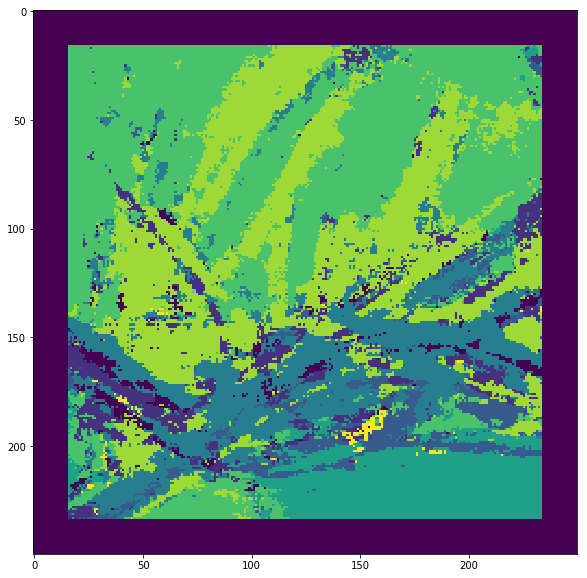

In [9]:
## classification of image

# import
imgc = gdal.Open(target)
img = imgc.ReadAsArray().astype(np.float32)

# normalize
for i in range(len(means)):
    img[i, :, :] = (img[i, :, :] - means[i]) / stds[i]

# classify
classification = np.zeros((img.shape[1], img.shape[2]))
Ypatch = np.zeros((1, num_classes))

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, modelpath)
    
    for x in range(0, img.shape[1]-patchSize):
        for y in range(0, img.shape[2]-patchSize):
            
            
            Xpatch = img[:, x:(x+patchSize), y:(y+patchSize)]
            Xpatch = np.moveaxis(Xpatch, 0, -1)
            Xpatch = np.expand_dims(Xpatch, axis=0)
            
            pred = sess.run(prediction, feed_dict={X: Xpatch, 
                                                   Y: Ypatch, 
                                                   keep_prob:1.0})
            classmax = np.argmax(pred)
            classification[x+int(patchSize/2), y+int(patchSize/2)] = classmax

# plot
plt.figure(figsize=(20,10))
imgplot = plt.imshow(classification)

# export
driver = gdal.GetDriverByName('GTiff')
df = driver.Create(target[:-4]+"_deep.tif", imgc.RasterXSize, imgc.RasterYSize, 1, gdal.GDT_Byte)
df.SetGeoTransform(imgc.GetGeoTransform())
df.SetProjection(imgc.GetProjectionRef())
#classification = classification.transpose()
df.GetRasterBand(1).WriteArray(classification)
df.FlushCache()
df = None

In [ ]:
#gdal.Translate("D:\\uni\\deep\\subsetv2.tif", fimg, format = 'GTiff', srcWin = [6000, 6000, 300, 500])